<a href="https://colab.research.google.com/github/Revandasaraju/Smart-_Traffic_Flow_Prediction-_Congestion_Detection_System/blob/main/Traffic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Prediction Model

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from warnings import filterwarnings
filterwarnings("ignore")


## Step 1 - Load Dataset

In [16]:

df = pd.read_csv("/content/Traffic.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (2976, 9)


,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [17]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


None

## Step 2 - Data Cleaning & Feature Engineering

In [18]:
# Convert Date + Time
df['DateTime'] = pd.to_datetime("2025-01-" + df['Date'].astype(str) + " " + df['Time'])
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Handle Traffic Situation only if present
if 'Traffic Situation' in df.columns:
    df['Traffic Situation'] = df['Traffic Situation'].str.capitalize()
    df = pd.get_dummies(df, columns=['Traffic Situation'], drop_first=True)

# Target variable
df['target'] = df['Total']

# Feature selection
X = df.drop(columns=['Time','Date','Day of the week','DateTime','Total','target'], errors='ignore')
y = df['target']


## Step 3 - Exploratory Data Analysis (EDA)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Time                      2976 non-null   object        
 1   Date                      2976 non-null   int64         
 2   Day of the week           2976 non-null   object        
 3   CarCount                  2976 non-null   int64         
 4   BikeCount                 2976 non-null   int64         
 5   BusCount                  2976 non-null   int64         
 6   TruckCount                2976 non-null   int64         
 7   Total                     2976 non-null   int64         
 8   DateTime                  2976 non-null   datetime64[ns]
 9   hour                      2976 non-null   int32         
 10  day_of_week               2976 non-null   int32         
 11  month                     2976 non-null   int32         
 12  is_wee

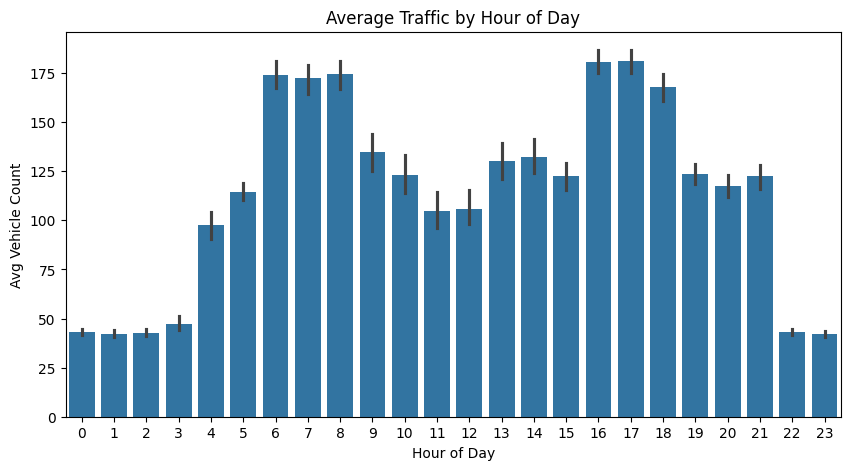

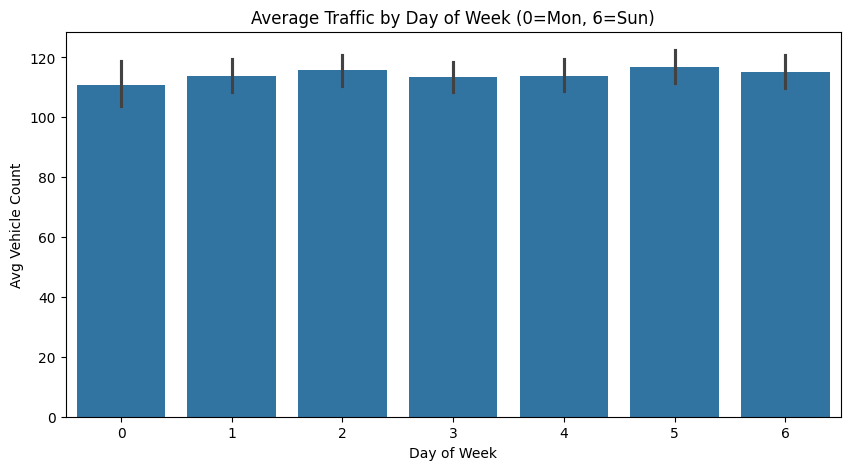

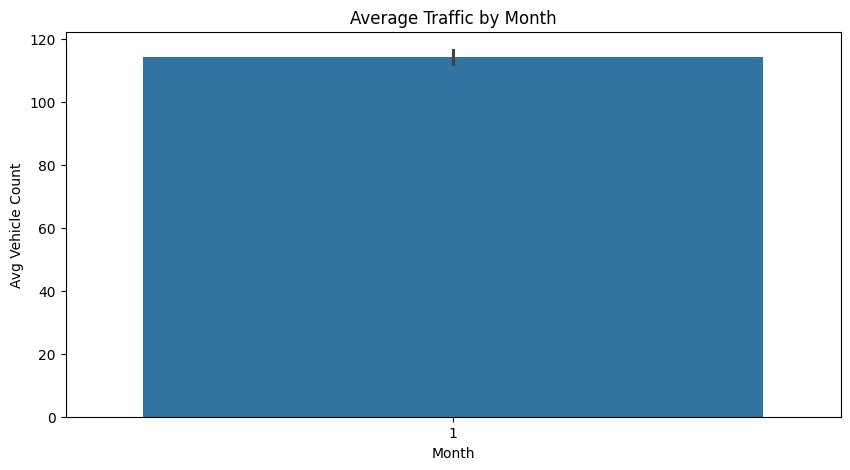

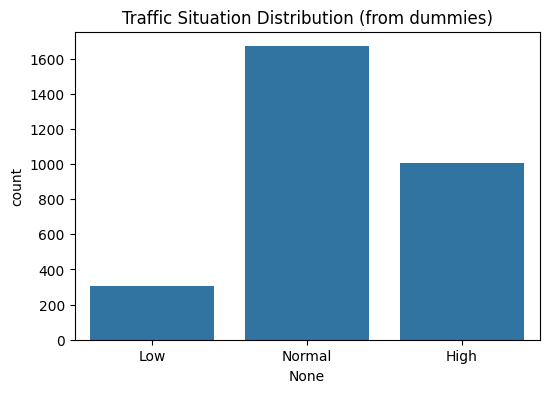

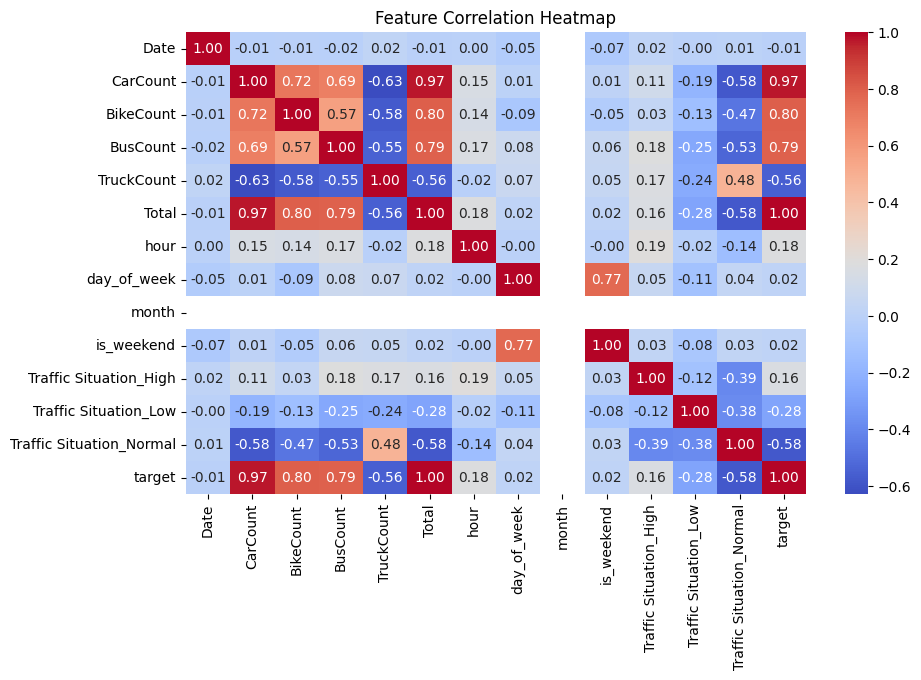

In [19]:
# =========================
# Exploratory Data Analysis
# =========================

import matplotlib.pyplot as plt
import seaborn as sns

# Preview dataset
print("Dataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# 1. Traffic by Hour of Day
plt.figure(figsize=(10,5))
sns.barplot(x="hour", y="target", data=df, estimator="mean")
plt.title("Average Traffic by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Vehicle Count")
plt.show()

# 2. Traffic by Day of Week
plt.figure(figsize=(10,5))
sns.barplot(x="day_of_week", y="target", data=df, estimator="mean")
plt.title("Average Traffic by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Avg Vehicle Count")
plt.show()

# 3. Traffic by Month
plt.figure(figsize=(10,5))
sns.barplot(x="month", y="target", data=df, estimator="mean")
plt.title("Average Traffic by Month")
plt.xlabel("Month")
plt.ylabel("Avg Vehicle Count")
plt.show()

# 4. Traffic Situation Distribution (handles both original & dummy columns)
traffic_cols = [col for col in df.columns if col.startswith("Traffic Situation")]

if 'Traffic Situation' in df.columns:
    # Original column exists
    plt.figure(figsize=(6,4))
    sns.countplot(x="Traffic Situation", data=df)
    plt.title("Traffic Situation Distribution")
    plt.show()

elif len(traffic_cols) > 0:
    # Only dummy columns exist, reconstruct the categories
    situation_series = df[traffic_cols].idxmax(axis=1).str.replace("Traffic Situation_", "")
    plt.figure(figsize=(6,4))
    sns.countplot(x=situation_series)
    plt.title("Traffic Situation Distribution (from dummies)")
    plt.show()
else:
    print("No Traffic Situation column found in dataset.")

# 5. Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


## Step 4 - Train-Test Split

In [20]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2380, 11) Test: (596, 11)


## Step 5 - Models

In [22]:

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


## Step 6 - Evaluation

In [23]:

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    return mae, rmse, r2

# Evaluate models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


Linear Regression -> MAE: 0.00, RMSE: 0.00, R²: 1.00
Random Forest -> MAE: 2.68, RMSE: 3.76, R²: 1.00
XGBoost -> MAE: 1.83, RMSE: 2.60, R²: 1.00


(1.827683448791504, np.float64(2.6045498578752917), 0.9979875683784485)

## Step 7 - Visualization

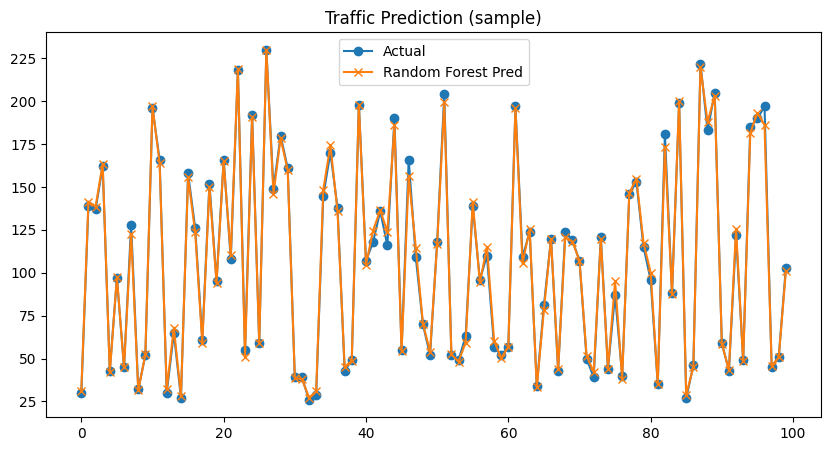

In [24]:

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label="Actual", marker='o')
plt.plot(y_pred_rf[:100], label="Random Forest Pred", marker='x')
plt.legend()
plt.title("Traffic Prediction (sample)")
plt.show()
